In [13]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize']

[6.0, 4.0]

In [210]:
from collections import defaultdict
import logging

from decimal import Decimal
import pandas as pd

from sim.netrual import Component
from trader.utils import should_convert2target


EOS = 'EOS'
OMG = 'OMG'
USDT = 'USDT'
NTL = 'NTL'


class BotLogger:
    @classmethod
    def debug(cls, *args):
        return logging.debug(*args)

    @classmethod
    def error(cls, *args):
        return logging.error(*args)

    @classmethod
    def info(cls, *args):
        return logging.info(*args)


bot_logger = BotLogger()


def read_csv(name, type='5m'):
    return pd.read_csv(
    './csv/binance_%s_%s_kline.csv' %(name, type),
    names=[name, 'open', 'high', 'low', 'last', 'type', 'timestamp']
)


def get_usdt_price_pandas(target_symbol):
    target2eth = read_csv('%s_ETH' % target_symbol)
    eth2usdt = read_csv('ETH_USDT')
    target2eth2usdt = pd.merge(target2eth, eth2usdt, on='timestamp')
    target2eth2usdt['price_usdt'] = target2eth2usdt['last_x'] * target2eth2usdt['last_y']
    return target2eth2usdt


class Exchange:
    num_ntl_each_round = Decimal('1000')

    def __init__(self, symbols):
        """
        :type components: dict[str, sim.netrual.Component]
        """
        self.current_index = 0
        self.symbols = symbols
        self.prices = {}
        self.components = {}
        self.current_prices = defaultdict(int)
        _other_symbol = None
        for symbol in symbols:
            self.components[symbol] = Component(symbol)
            if symbol != USDT:
                _other_symbol = symbol
            else:
                continue
            self.prices[symbol] = get_usdt_price_pandas(symbol)

        self.prices[USDT] = pd.Series(
            dict(
                timestamp=self.prices[_other_symbol].timestamp,
                price_usdt=[1, ] * len(self.prices[_other_symbol]),
            )
        )

    def update_kline(self):
        for symbol in self.symbols:
            component = self.components[symbol]
            prices = self.prices[symbol]
            try:
                ts = prices['timestamp'][self.current_index]
            except KeyError:
                raise ValueError("Data is gone.")
            component(ts)
            self.current_prices[symbol] = prices['price_usdt'][self.current_index]
        self.current_index += 1

    def bootstrap(self):
        self.update_kline()
        for component in self.components.values():
            component.auction('the-god', Decimal('8'))

    def get_flat_price(self, symbol):
        return Decimal(self.current_prices[symbol])

    def get_ntl_min_price(self, token_name):
        component = self.components[token_name]
        return Decimal(component.min_bid)

    def redeem(self, symbol, sender_name):
        """
        return token.
        """
        component = self.components[symbol]
        _redeemed = component.redeem_all(sender_name)
        num_redeemed = Decimal('0')
        for redeemed in _redeemed:
            num_redeemed += Decimal(redeemed)
        if num_redeemed is False:
            return None
        return num_redeemed

    def buy(self, num_token, symbol, sender_name):
        """
        To buy given number of NTL buy token.
        Return num_amount of ntl if succeed, None if failed
        :param num_token: 10
        :param symbol: for example EOS
        :param sender_name: trader_name
        """
        component = self.components[symbol]
        result = component.auction(sender_name, num_token)
        if result:
            return self.num_ntl_each_round
        return None

    @classmethod
    def get_ntl_each_round(cls):
        return cls.num_ntl_each_round


class Trader:
    """
    A trader that always wants more flat-money.
    """
    name = 'greed-is-good'

    def __init__(self, source, target, assets, exchange):
        """
        :type exchange: Exchange
        """
        self.assets = assets
        self.source = source
        self.target = target
        self.exchange = exchange

    @staticmethod
    def get_price_with_impact_cost(min_price, premium_rate):
        return min_price * (1 + premium_rate or 0)

    @staticmethod
    def get_premium_rate():
        # return random.randint(1, 20) / 100.0
        return 0.01

    def one_cycle(self):
        """
        Should be run each round.
        """
        source_ntl_price = self.exchange.get_ntl_min_price(self.source)
        target_ntl_price = self.exchange.get_ntl_min_price(self.target)
        source_market_price = self.exchange.get_flat_price(self.source)
        target_market_price = self.exchange.get_flat_price(self.target)

        premium_rate = Decimal(str(self.get_premium_rate()))
        if should_convert2target(
            source_market_price,
            source_ntl_price,
            target_market_price,
            target_ntl_price,
            premium_rate=premium_rate,
        ):
            if self.do_transition(self.source, self.target, premium_rate):
                return lambda : self.do_redeem(self.source, self.target)
        if should_convert2target(
            source_market_price,
            source_ntl_price,
            target_market_price,
            target_ntl_price,
            premium_rate=premium_rate,
        ):
            if self.do_transition(self.target, self.source, premium_rate):
                return lambda: self.do_redeem(self.target, self.source)

    def do_transition(self, source, target, premium_rate):
        price = self.exchange.get_ntl_min_price(source)
        price = self.get_price_with_impact_cost(price, premium_rate)
        source_cost = price
        assert price > 0

        if self.assets[source] < source_cost:
            bot_logger.error(
                "Source cost is too much, %s, price is %s"
                % (source_cost, price)
            )
            return False
        ntl_got = self.exchange.buy(source_cost, source, self.name)
        if ntl_got is None:
            bot_logger.error(
                "You do auction with cycle: %s ntl_got: %s"
                % (
                    self.exchange.components[self.source].cycle,
                    ntl_got,
                )
            )
            return False
        self.assets[NTL] += ntl_got
        self.assets[source] -= source_cost
        bot_logger.debug("buy succeed: %s" % self.assets)
        return True

    def do_redeem(self, source, target):
        bot_logger.debug(
            "%s: redeeming, you have %s, accounts %s"
            % (
                self.exchange.components[target].cycle,
                self.assets,
                self.exchange.components[target].accounts,
            )
        )
        num_target_got = self.exchange.redeem(
            target,
            self.name
        )
        if num_target_got is None:
            bot_logger.error(
                "%s: Failed to redeem, you have %s, accounts %s"
                % (
                    self.exchange.components[target].cycle,
                    self.assets,
                    self.exchange.components[target].accounts,
                )
            )
            return False
        self.assets[NTL] = Decimal("0")
        self.assets[target] += num_target_got
        return True


class Statistics:

    def __init__(self):
        self.ntl_prices = defaultdict(list)
        self.reversed_amounts = defaultdict(list)
        self.flat_prices = defaultdict(list)
        self.ntl_total_supply_amounts = defaultdict(list)
        self.ts = []

    def record(self, exchange):
        self.ts.append(exchange.components['EOS'].timestamp)
        for symbol in exchange.symbols:
            self.ntl_prices[symbol].append(
                exchange.components[symbol].min_bid
            )
            self.reversed_amounts[symbol].append(
                exchange.components[symbol].reserve
            )
            self.ntl_total_supply_amounts[symbol].append(
                exchange.components[symbol].total_supply
            )
            self.flat_prices[symbol].append(
                exchange.get_flat_price(symbol)
            )

    def get_data_frame(self, exchange):
        data_frames = []
        for symbol in exchange.symbols:
            all_data = dict(
                (
                    (
                        'ntl_%s_price' % symbol,
                        pd.Series(
                            self.ntl_prices[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_reserved' % symbol,
                        pd.Series(
                            self.reversed_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        'ntl_total_supply',
                        pd.Series(
                            self.ntl_total_supply_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_flat_price' % symbol,
                        pd.Series(
                            [float(price) for price in self.flat_prices[symbol]],
                            index=self.ts,
                        )
                    ),
                )
            )
            data_frames.append(
                pd.DataFrame(all_data)
            )
        return data_frames



def run():
    exchange = Exchange([EOS, OMG])
    statistic_tool = Statistics()
    trader = Trader(
        source=EOS,
        target=OMG,
        assets={
            EOS:  Decimal('1000'),
            OMG: Decimal('1000'),
            USDT: Decimal('1000'),
            NTL: Decimal('0'),
        },
        exchange=exchange,
    )
    exchange.bootstrap()
    fn = None
    counter = 0
    while True:
        counter += 1
        try:
            exchange.update_kline()
        except ValueError:
            bot_logger.info("Has no kline data, exited.")
            break
        statistic_tool.record(exchange)
        if callable(fn):
            fn()
        fn = trader.one_cycle()
    return statistic_tool.get_data_frame(exchange)


def main():
    result = run()
    return result



In [211]:
result = main()


ERROR:root:You do auction with cycle: 0 ntl_got: None
ERROR:root:You do auction with cycle: 0 ntl_got: None
ERROR:root:You do auction with cycle: 5 ntl_got: None
ERROR:root:You do auction with cycle: 10 ntl_got: None
ERROR:root:You do auction with cycle: 15 ntl_got: None
ERROR:root:You do auction with cycle: 20 ntl_got: None
ERROR:root:You do auction with cycle: 25 ntl_got: None
ERROR:root:You do auction with cycle: 30 ntl_got: None
ERROR:root:You do auction with cycle: 35 ntl_got: None
ERROR:root:You do auction with cycle: 40 ntl_got: None
ERROR:root:You do auction with cycle: 45 ntl_got: None
ERROR:root:You do auction with cycle: 50 ntl_got: None
ERROR:root:You do auction with cycle: 55 ntl_got: None
ERROR:root:You do auction with cycle: 60 ntl_got: None
ERROR:root:You do auction with cycle: 65 ntl_got: None
ERROR:root:You do auction with cycle: 70 ntl_got: None
ERROR:root:You do auction with cycle: 75 ntl_got: None
ERROR:root:You do auction with cycle: 80 ntl_got: None
ERROR:root:Yo

EOS:: New cycle 1
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 21000, 'greed-is-good': 1000}
OMG:: New cycle 1
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 22000, 'greed-is-good': 1000}
EOS:: New cycle 2
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
OMG:: New cycle 2
redeeming 1000 for OMG, reserve is 10008.0
redeeming 1000 for OMG, reserve is 10000.0
EOS:: New cycle 3
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 3
redeeming 1000 for OMG, reserve is 9999.0
EOS:: New cycle 4
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 4
redeeming 1000 for OMG, reserve is 9998.0
EOS:: New cycle 5
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 5
redeeming 1000 for O

ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:You do auction with cycle: 145 ntl_got: None
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309

ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856


EOS:: New cycle 141
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 141
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
redeeming 1000 for EOS, reserve is 10991.105895492961
redeeming 1000 for EOS, reserve is 10973.372173755408
EOS:: New cycle 142
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 142
redeeming 1000 for OMG, reserve is 9754.2408
EOS:: New cycle 143
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 143
redeeming 1000 for OMG, reserve is 9746.08
EOS:: New cycle 144
OMG:: New cycle 144
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
redeeming 1000 for EOS, reserve is 10991.105895492961
EOS:: New cycle 145
Found last Winner
sent 1000 NTL to 

ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:You do auction with cycle: 265 ntl_got: None
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309

Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 261
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
redeeming 1000 for EOS, reserve is 10991.105895492961
redeeming 1000 for EOS, reserve is 10973.372173755408
EOS:: New cycle 262
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 262
redeeming 1000 for OMG, reserve is 9754.2408
EOS:: New cycle 263
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 263
redeeming 1000 for OMG, reserve is 9746.08
EOS:: New cycle 264
OMG:: New cycle 264
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
redeeming 1000 for EOS, reserve is 10991.105895492961
EOS:: New cycle 265
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 100

ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:You do auction with cycle: 385 ntl_got: None
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309

EOS:: New cycle 377
OMG:: New cycle 377
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
redeeming 1000 for EOS, reserve is 10991.105895492961
redeeming 1000 for EOS, reserve is 10973.372173755408
EOS:: New cycle 378
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 378
redeeming 1000 for OMG, reserve is 9754.2408
EOS:: New cycle 379
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 379
redeeming 1000 for OMG, reserve is 9746.08
EOS:: New cycle 380
OMG:: New cycle 380
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
redeeming 1000 for EOS, reserve is 10991.105895492961
EOS:: New cycle 381
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 381
Found last Winn

ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:You do auction with cycle: 485 ntl_got: None
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309

EOS:: New cycle 481
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 481
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
redeeming 1000 for EOS, reserve is 10991.105895492961
redeeming 1000 for EOS, reserve is 10973.372173755408
EOS:: New cycle 482
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 482
redeeming 1000 for OMG, reserve is 9754.2408
EOS:: New cycle 483
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 483
redeeming 1000 for OMG, reserve is 9746.08
EOS:: New cycle 484
OMG:: New cycle 484
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
redeeming 1000 for EOS, reserve is 10991.105895492961
EOS:: New cycle 485
Found last Winner
sent 1000 NTL to 

ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:You do auction with cycle: 595 ntl_got: None
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.73372173755405377448823856, price is 17.73372173755405377448823856
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309223124365
ERROR:root:Source cost is too much, 17.91105895492959309223124365, price is 17.91105895492959309

EOS:: New cycle 591
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 591
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 2000}
redeeming 1000 for EOS, reserve is 10991.105895492961
redeeming 1000 for EOS, reserve is 10973.372173755408
EOS:: New cycle 592
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 592
redeeming 1000 for OMG, reserve is 9754.2408
EOS:: New cycle 593
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
OMG:: New cycle 593
redeeming 1000 for OMG, reserve is 9746.08
EOS:: New cycle 594
OMG:: New cycle 594
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 22000, 'greed-is-good': 1000}
redeeming 1000 for EOS, reserve is 10991.105895492961
EOS:: New cycle 595
Found last Winner
sent 1000 NTL to 

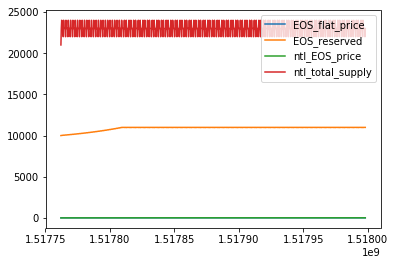

In [212]:
result[0].plot()


/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


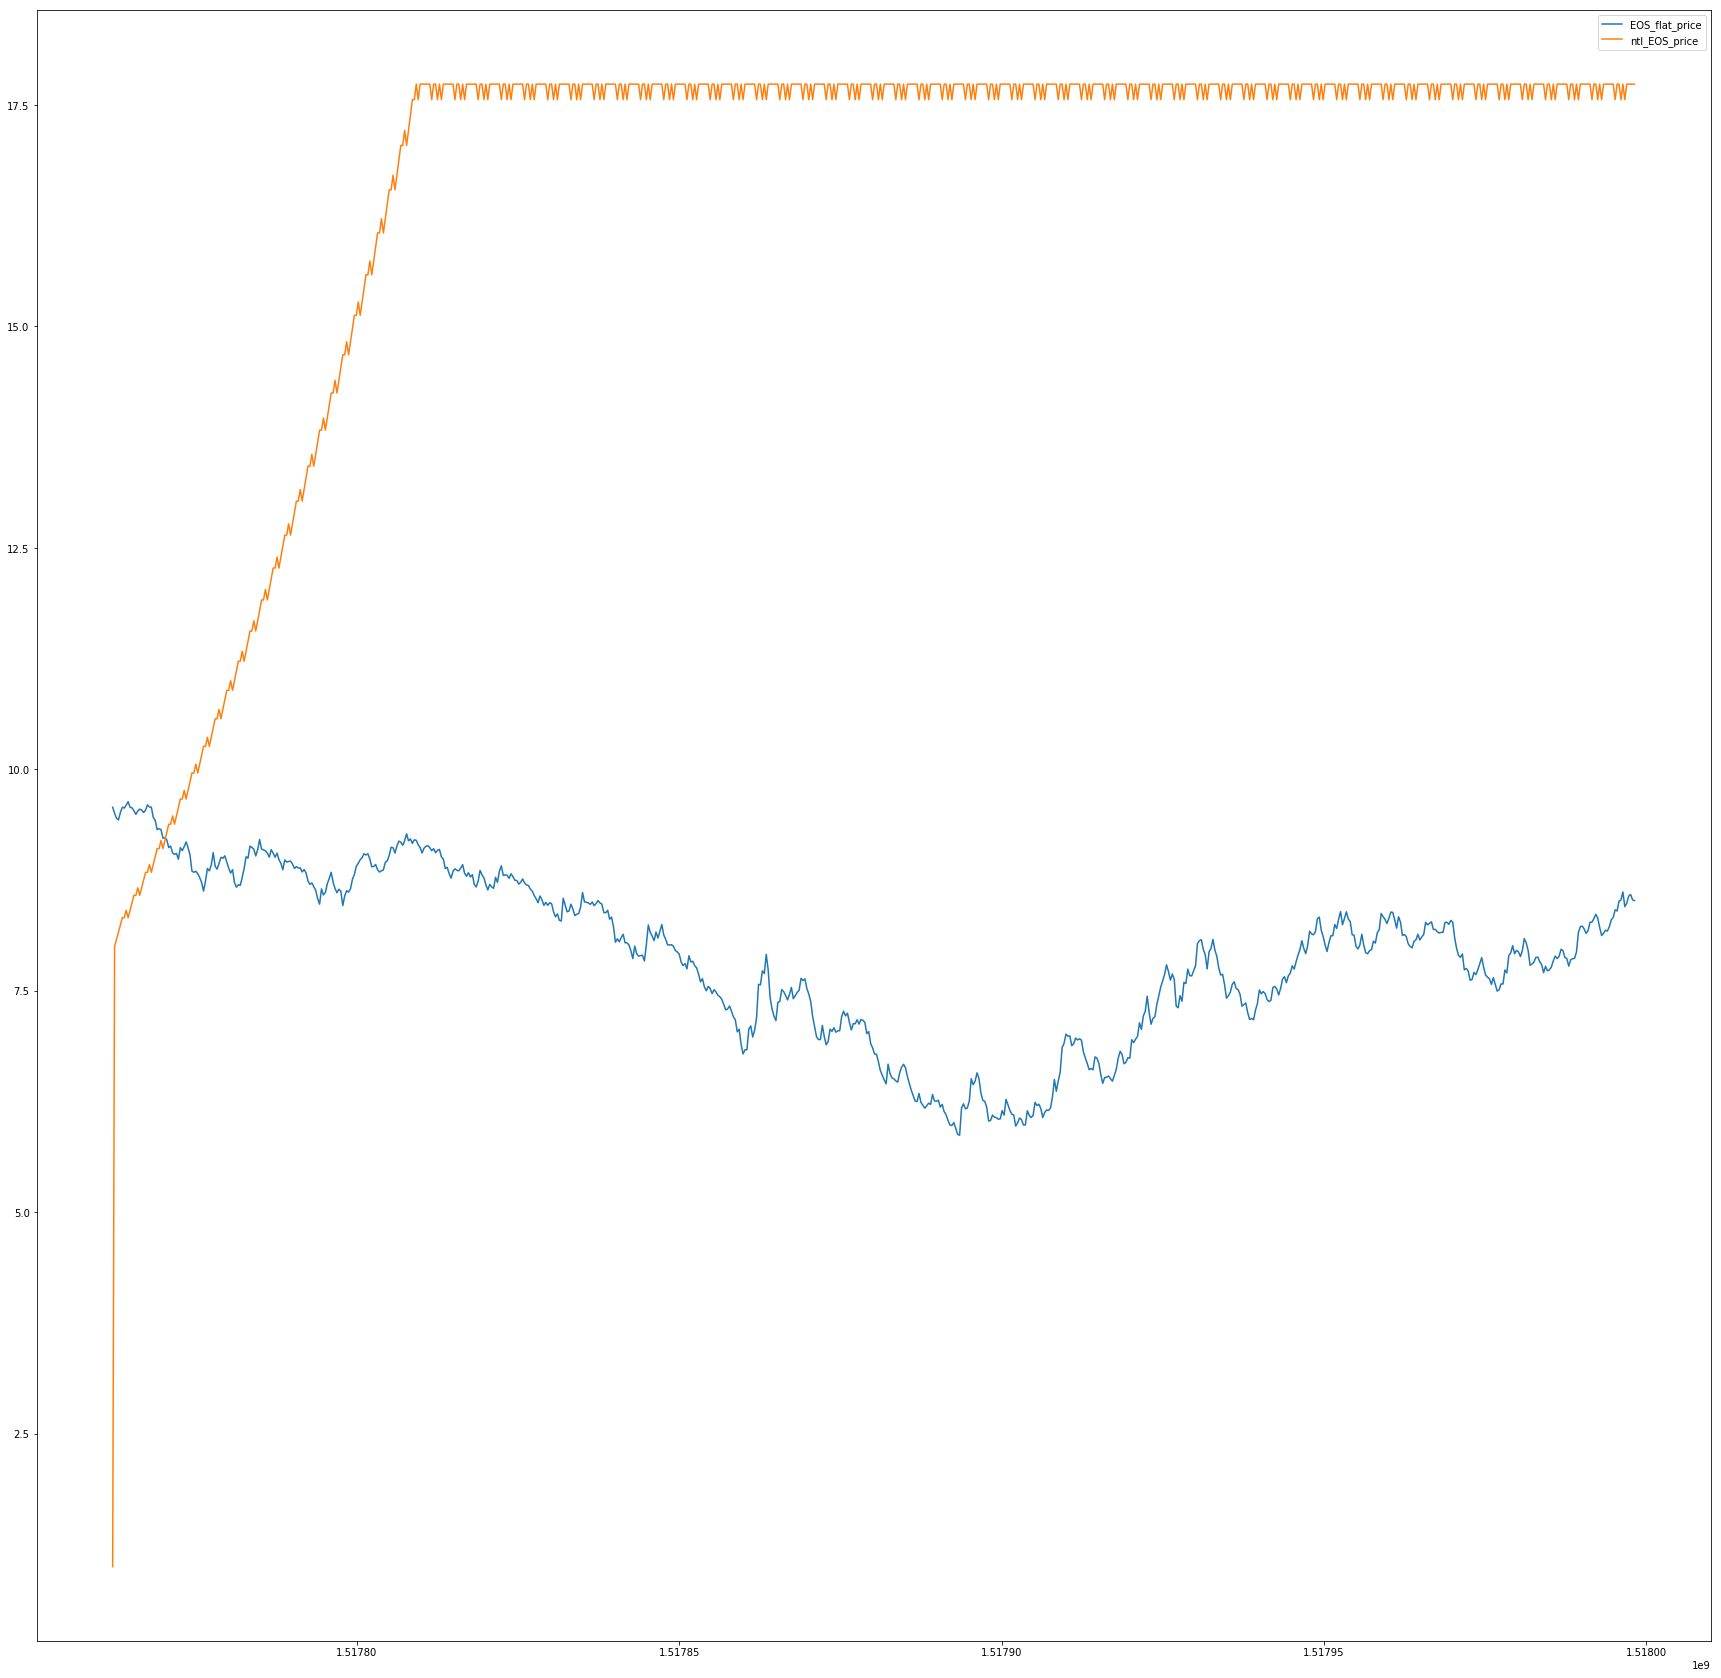

In [213]:
result[0].plot(y=['EOS_flat_price', 'ntl_EOS_price'], figsize=(30, 30))

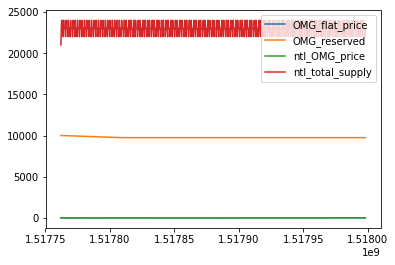

In [214]:
result[1].plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


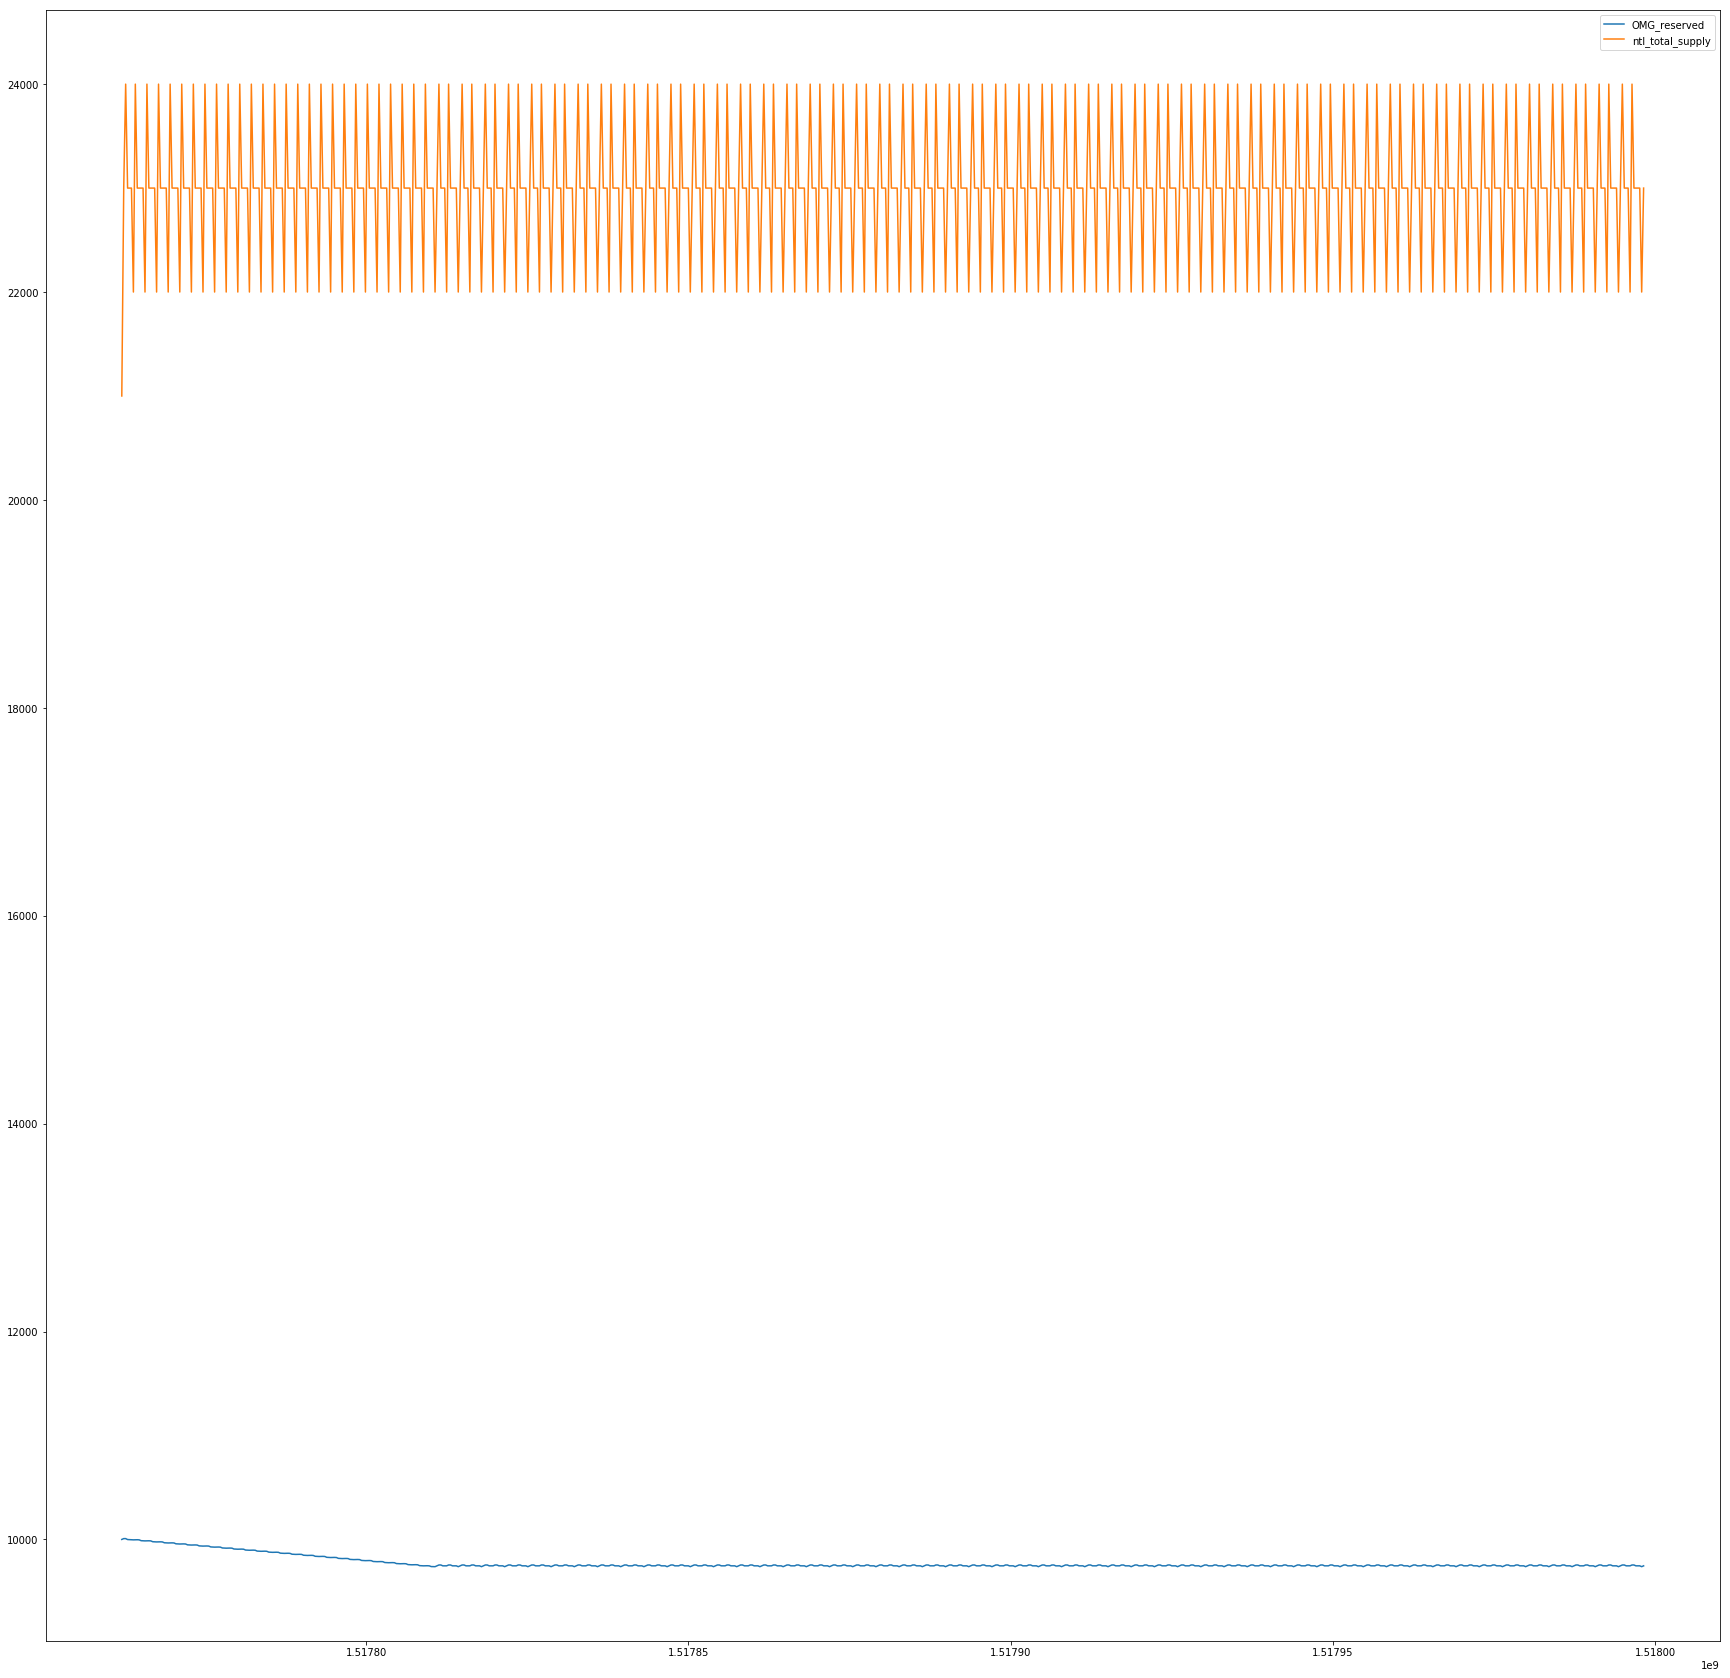

In [215]:
result[1].plot(y=['OMG_reserved', 'ntl_total_supply'], figsize=(30, 30))

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


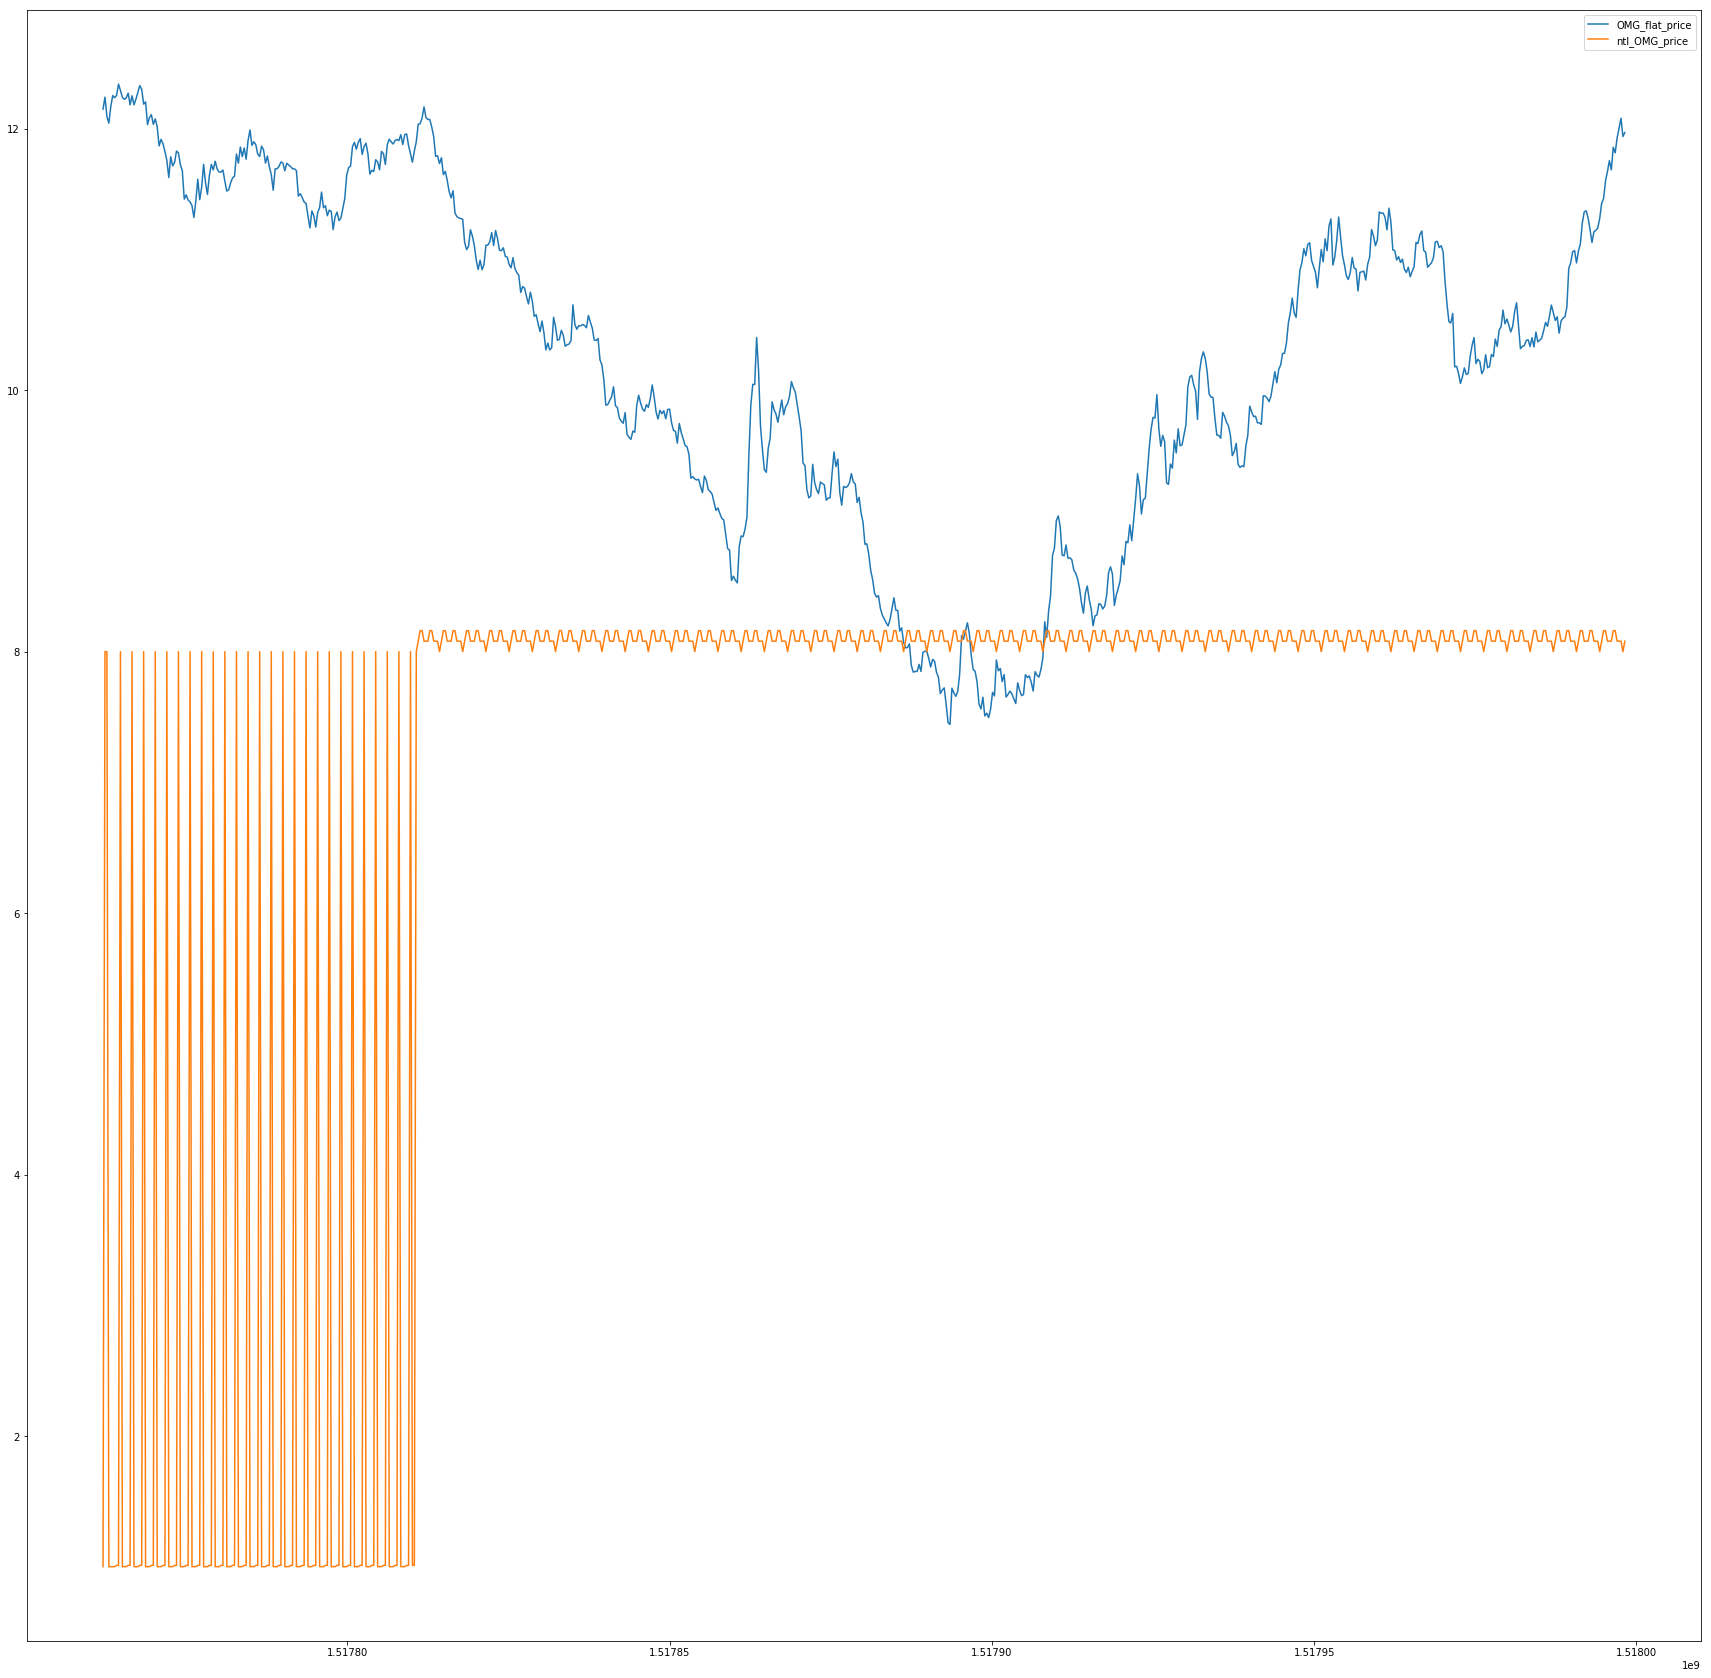

In [216]:
result[1].plot(y=['OMG_flat_price', 'ntl_OMG_price'], figsize=(30, 30))

In [217]:
concated = pd.merge(result[0], result[1], left_index=True, right_index=True)

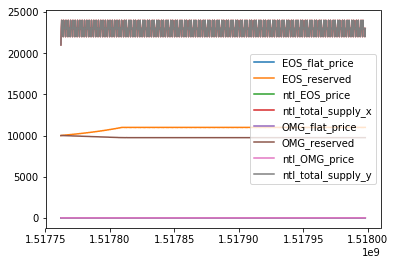

In [218]:
concated.plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


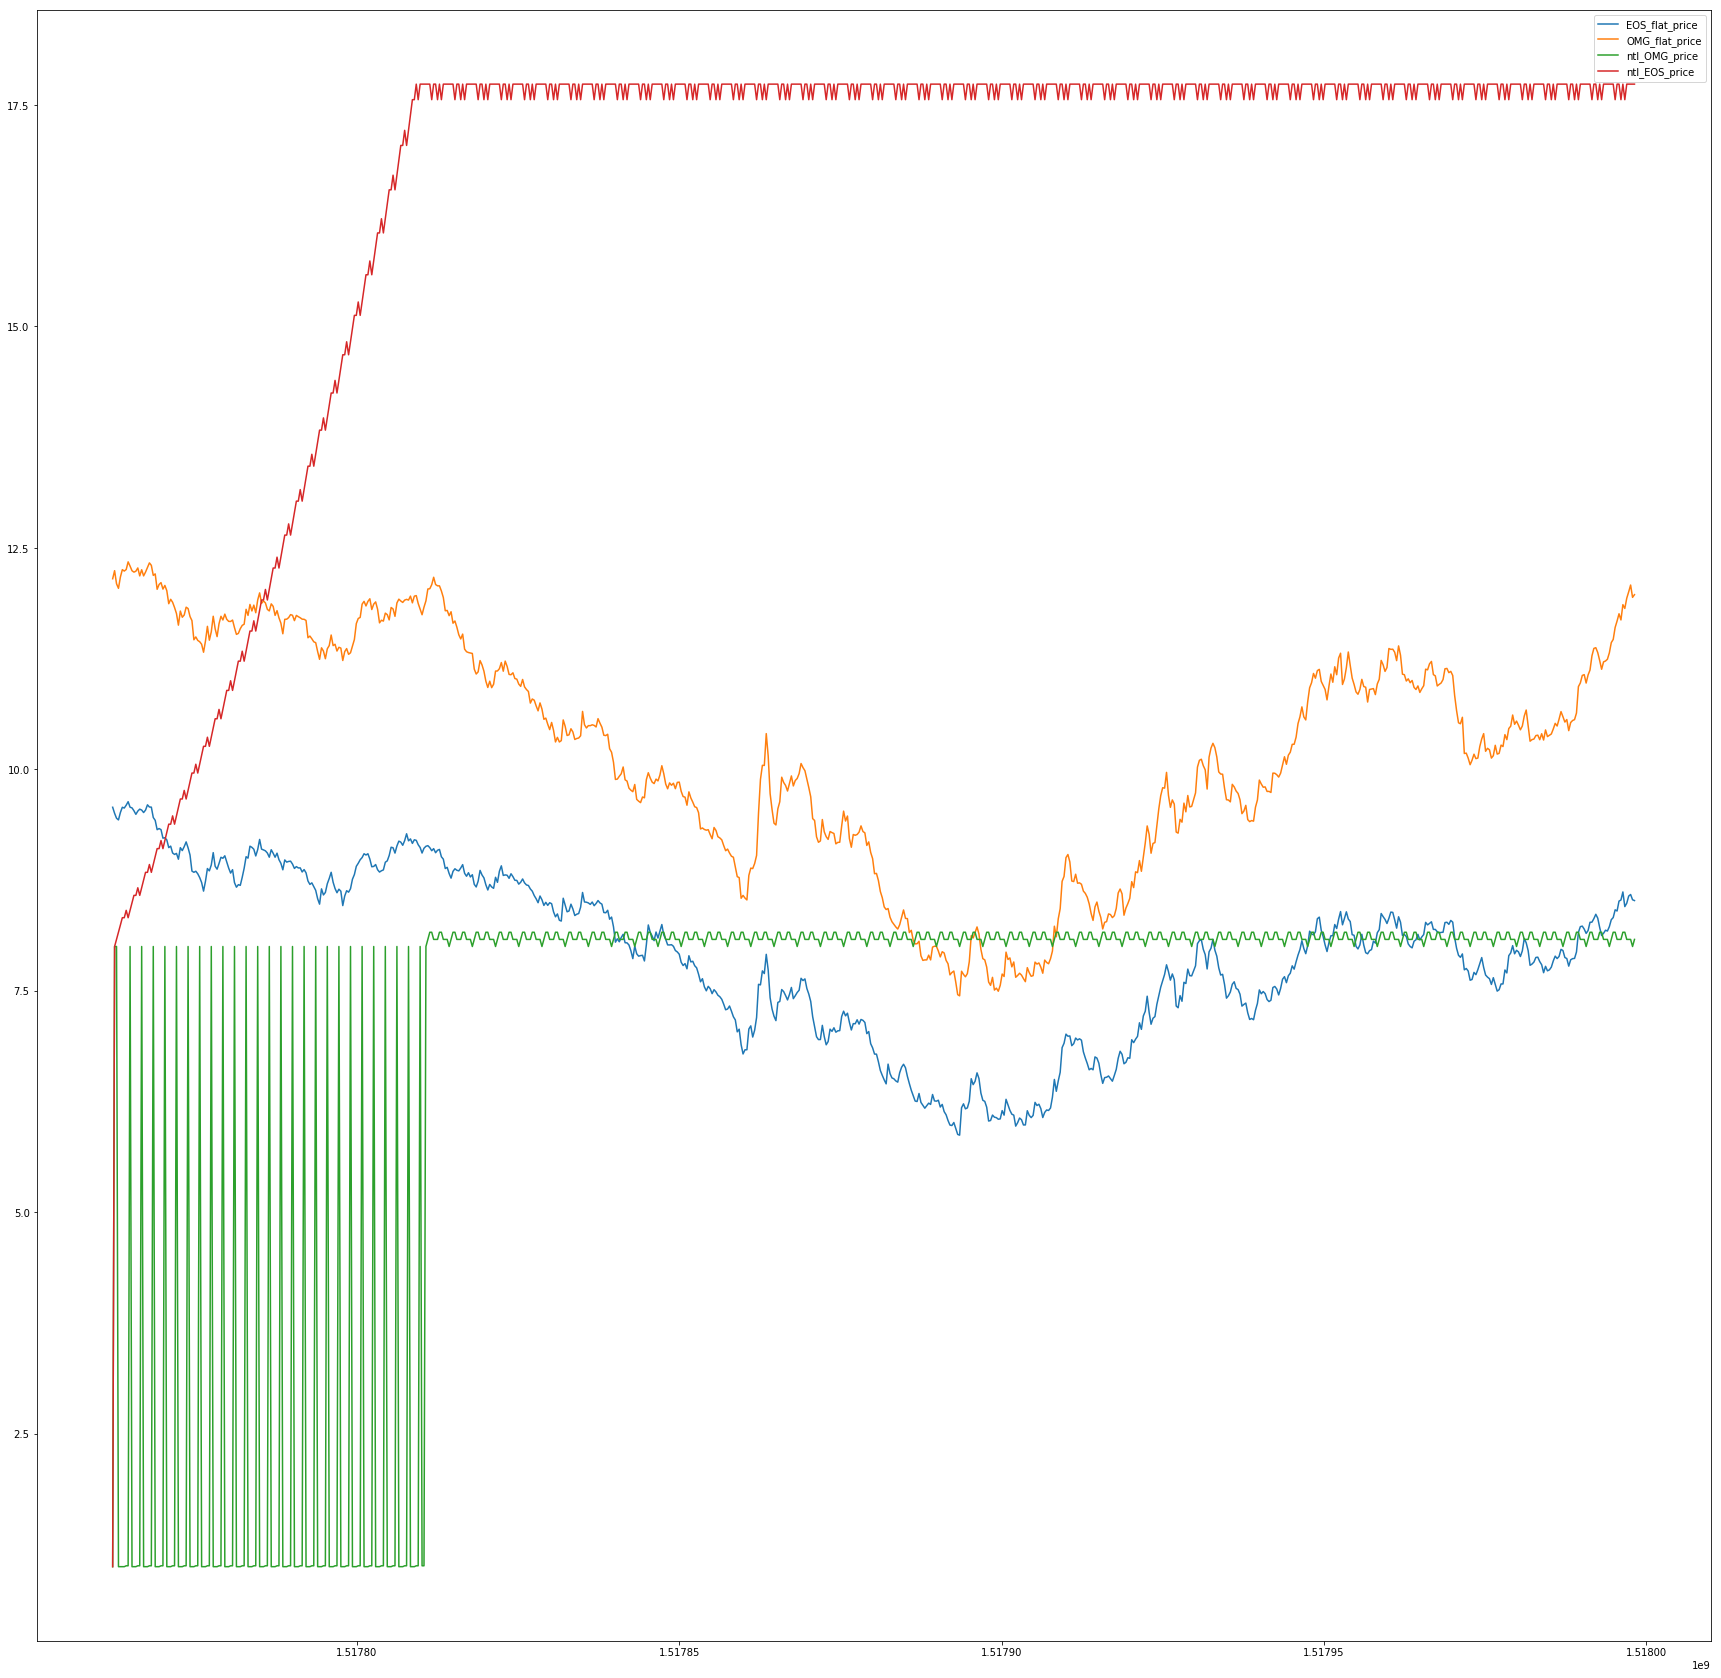

In [219]:
y = ['EOS_flat_price', 'OMG_flat_price']
y = ['EOS_flat_price', 'OMG_flat_price', 'ntl_OMG_price', 'ntl_EOS_price']
concated.plot(y=y, figsize=(30, 30))

In [224]:
concated['ntl_EOS_flat_price'] = concated['ntl_EOS_price'] * concated['EOS_flat_price'] 
concated['ntl_OMG_flat_price'] = concated['ntl_OMG_price'] * concated['OMG_flat_price']
concated['ntl_OMG_flat_price'] = concated['ntl_OMG_flat_price'].div(10)
concated['ntl_EOS_flat_price'] = concated['ntl_EOS_flat_price'].div(10)
concated['OMG_reserved_valued'] = concated['OMG_reserved'] * concated['OMG_flat_price'] 
concated['EOS_reserved_valued'] = concated['EOS_reserved'] * concated['EOS_flat_price']
concated['ntl_total_value'] = concated['EOS_reserved_valued'] + concated['OMG_reserved_valued']
concated['ntl_flat_price'] = concated['ntl_total_value'] / concated['ntl_total_supply_x']

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


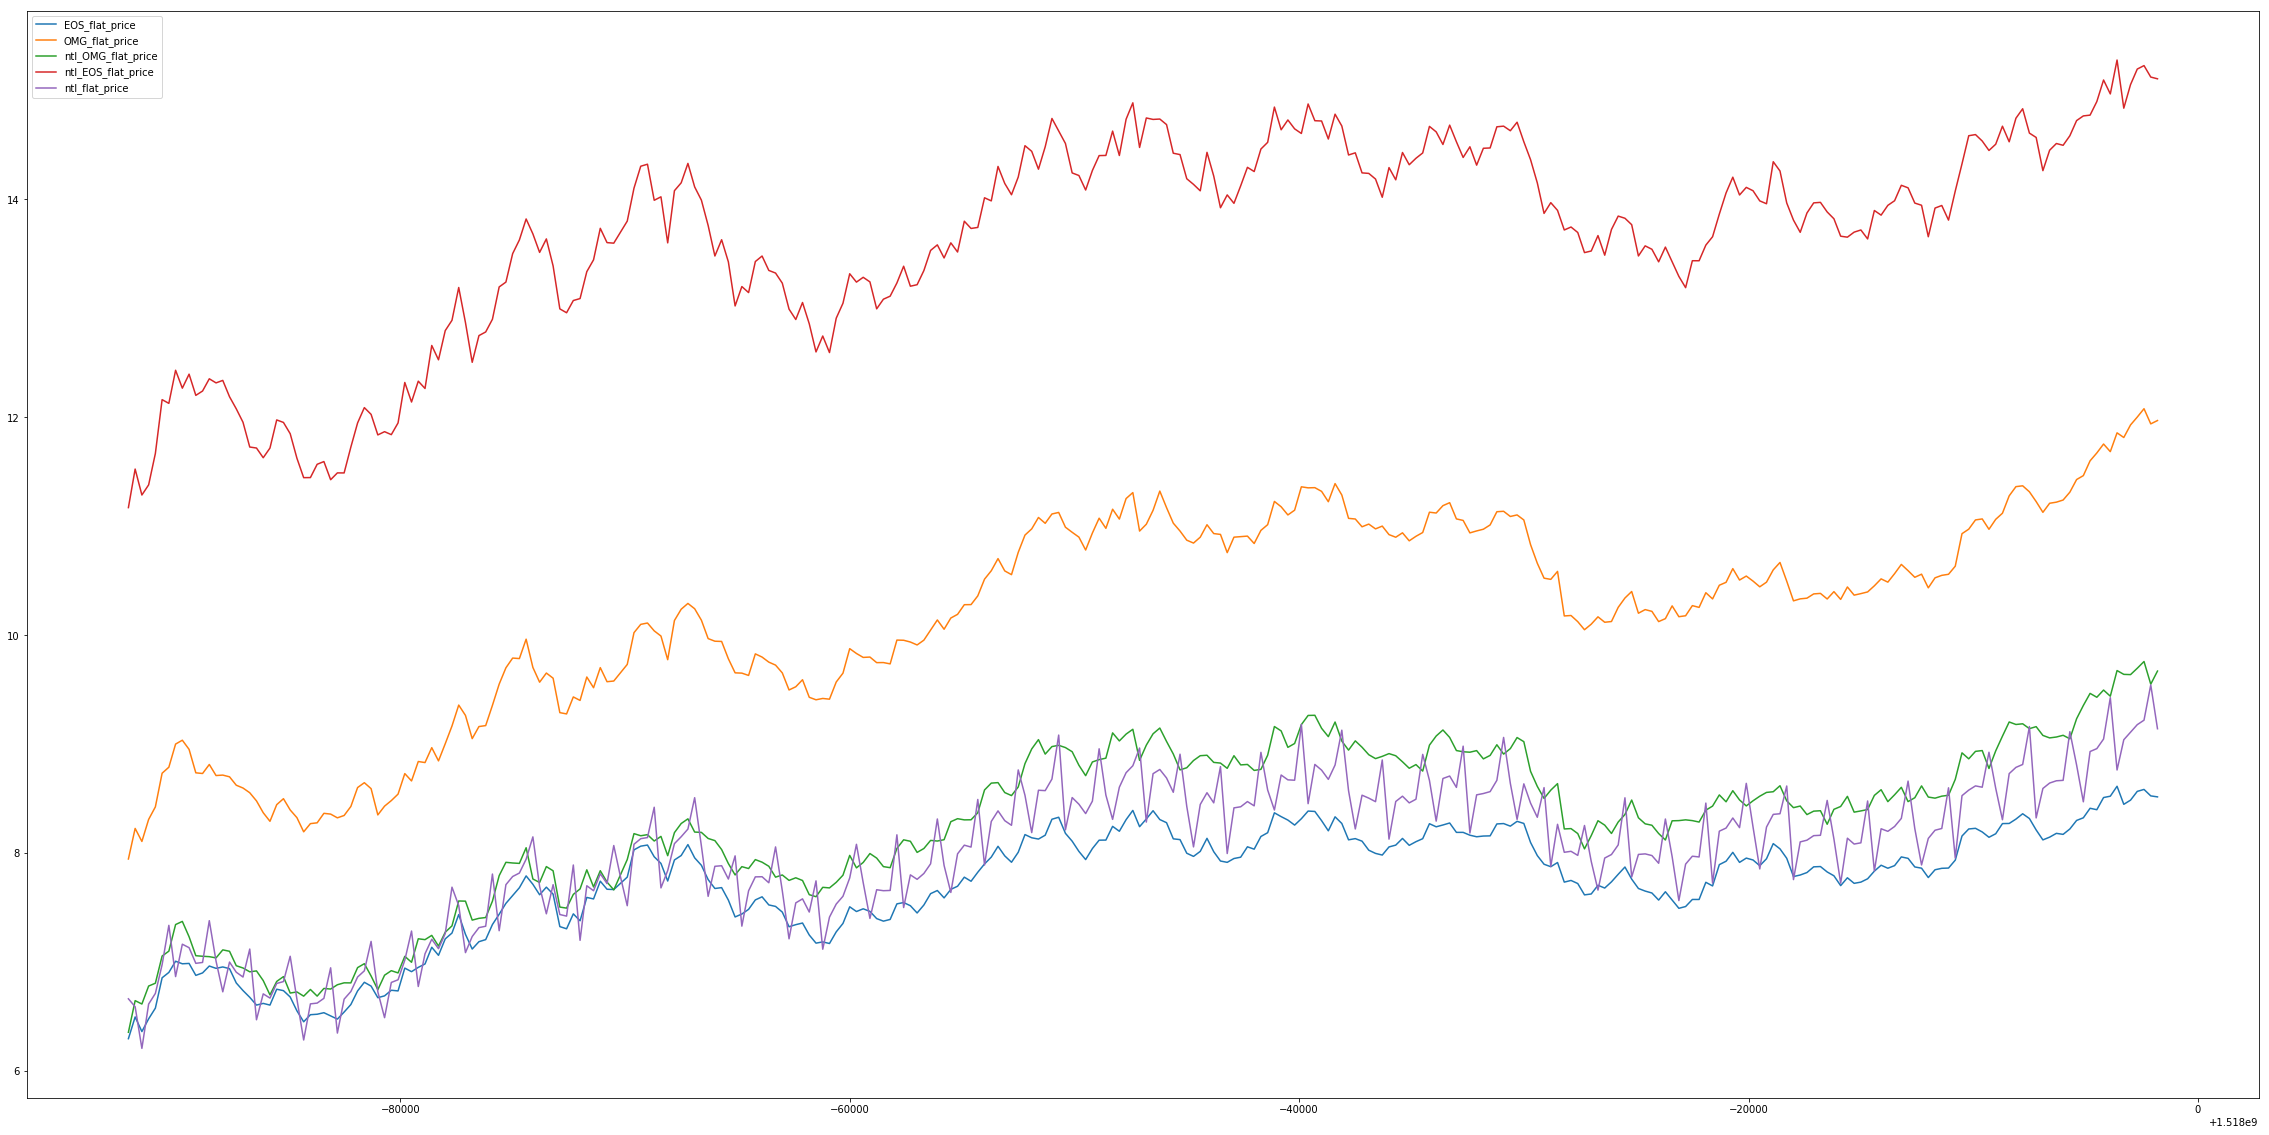

In [225]:
y = [
    'EOS_flat_price', 'OMG_flat_price', 
    'ntl_OMG_flat_price', 'ntl_EOS_flat_price', 
    'ntl_flat_price',
]
# y = ['EOS_flat_price', 'OMG_flat_price', 'ntl_OMG_price', 'ntl_OMG_flat_price']
concated = concated[162:]
concated.plot(y=y, figsize=(40, 20))

In [226]:
print(concated['ntl_flat_price'].std())
print(concated['OMG_flat_price'].std())
print(concated['EOS_flat_price'].std())

0.680294802074
0.941012101168
0.528515487736


In [229]:
print(concated['ntl_flat_price'].var())
print(concated['ntl_EOS_flat_price'].var())
print(concated['ntl_OMG_flat_price'].var())
print(concated['OMG_flat_price'].var())
print(concated['EOS_flat_price'].var())

0.462801017729
0.879223734708
0.582038155083
0.885503774545
0.279328620777
